In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add,LeakyReLU
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#,save_img

# Set some parameters
im_width = 101
im_height = 101
im_chan = 1
basicpath = '../input/'
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'

img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]
    
# Loading of training/testing ids and depths

train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


4000

In [2]:
train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in train_df.index]
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in train_df.index]

/usr/local/lib/python3.5/dist-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Text(0.5,0,'Coverage class')

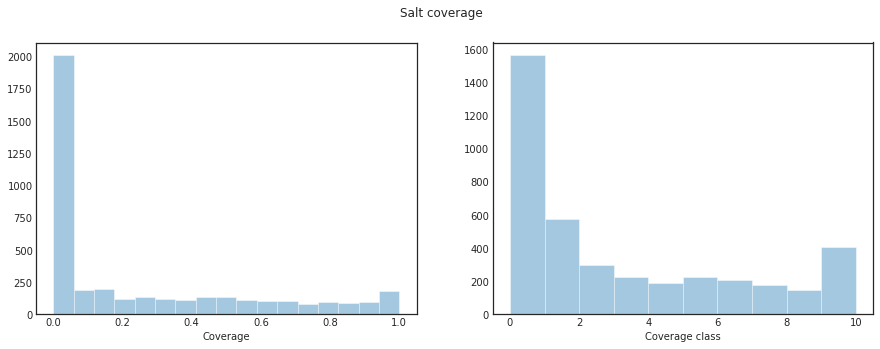

In [3]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5,1,'Depth distribution')

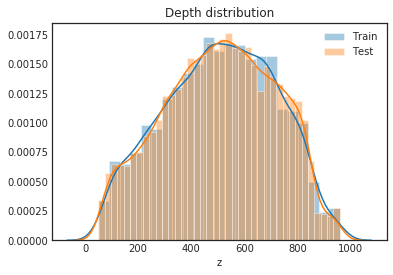

In [4]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [5]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [6]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.3)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.3)(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = LeakyReLU(alpha=0.3)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = LeakyReLU(alpha=0.3)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = LeakyReLU(alpha=0.3)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = LeakyReLU(alpha=0.3)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = LeakyReLU(alpha=0.3)(convm)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = LeakyReLU(alpha=0.3)(uconv4)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = LeakyReLU(alpha=0.3)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = LeakyReLU(alpha=0.3)(uconv2)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = LeakyReLU(alpha=0.3)(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    # Jiaxin fin that if all zeros, then, the background is treated as object
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in > 0.5 # added by sgx 20180728
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    #print("metric = ",metric)
    return np.mean(metric)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float64)
    return metric_value

#Data augmentation
tmp_x = [x_train, [np.fliplr(x) for x in x_train],[np.flipud(x) for x in x_train],
#          [np.rot90(x,1) for x in x_train],
#          [np.rot90(x,2) for x in x_train],
#          [np.rot90(x,3) for x in x_train],
        ]
x_train2 = np.concatenate(tmp_x, axis=0)
tmp_y = [y_train, [np.fliplr(x) for x in y_train],[np.flipud(x) for x in y_train],
#          [np.rot90(x,1) for x in y_train],
#          [np.rot90(x,2) for x in y_train],
#          [np.rot90(x,3) for x in y_train],
        ]
y_train2 = np.concatenate(tmp_y, axis=0)
x_train2,y_train2 = shuffle(x_train2,y_train2,random_state=666)
print(x_train2.shape)
print(y_valid.shape)

(9600, 101, 101, 1)
(800, 101, 101, 1)


In [7]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
# input_layer2 = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)

# del model
model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[my_iou_metric])

model.summary()
best_model_f = "./models/unet_best1_adj.model"

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 101, 101, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
conv2d_2 (

In [8]:

early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=8, verbose=1)
model_checkpoint = ModelCheckpoint(best_model_f, monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.2, patience=5, min_lr=0.00001, verbose=1)


epochs = 200
batch_size = 32

# loads
model.load_weights(best_model_f)

history = model.fit(x_train2, y_train2,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=2)

# only flip aug, PB 0.797
# Epoch 41/200
#  - 142s - loss: 0.0759 - my_iou_metric: 0.7924 - val_loss: 0.1502 - val_my_iou_metric: 0.7970
# Epoch 00041: val_my_iou_metric improved from 0.79200 to 0.79700, 
#     saving model to ./models/unet_best1_adj.model

# more rot aug, PB 0.784 ; flipud TTA 0.788 ; direct simple filter with old threshold, 0.790
# Epoch 39/200
#  - 262s - loss: 0.0881 - my_iou_metric: 0.7831 - val_loss: 0.1385 - val_my_iou_metric: 0.7816
# Epoch 00039: val_my_iou_metric improved from 0.77963 to 0.78163, 
#     saving model to ./models/unet_best1_adj.model

# rm rot aug, flipud TTA, simple filter, PB 0.792
# Epoch 32/200
#  - 133s - loss: 0.0891 - my_iou_metric: 0.7776 - val_loss: 0.1286 - val_my_iou_metric: 0.7843
# Epoch 00032: val_my_iou_metric improved from 0.78212 to 0.78425, 
#     saving model to ./models/unet_best1_adj.model

# alpha=0.3, load and retrain, PB 0.793
# Epoch 21/200
#  - 134s - loss: 0.0815 - my_iou_metric: 0.7872 - val_loss: 0.1344 - val_my_iou_metric: 0.7869

Train on 9600 samples, validate on 800 samples
Epoch 1/200
 - 146s - loss: 0.1614 - my_iou_metric: 0.6532 - val_loss: 0.1416 - val_my_iou_metric: 0.7419

Epoch 00001: val_my_iou_metric improved from -inf to 0.74188, saving model to ./models/unet_best1_adj.model
Epoch 2/200
 - 134s - loss: 0.1322 - my_iou_metric: 0.7021 - val_loss: 0.1766 - val_my_iou_metric: 0.7126

Epoch 00002: val_my_iou_metric did not improve from 0.74188
Epoch 3/200
 - 134s - loss: 0.1311 - my_iou_metric: 0.7126 - val_loss: 0.1882 - val_my_iou_metric: 0.6960

Epoch 00003: val_my_iou_metric did not improve from 0.74188
Epoch 4/200
 - 134s - loss: 0.1298 - my_iou_metric: 0.7139 - val_loss: 0.1468 - val_my_iou_metric: 0.7373

Epoch 00004: val_my_iou_metric did not improve from 0.74188
Epoch 5/200
 - 134s - loss: 0.1306 - my_iou_metric: 0.7198 - val_loss: 0.1622 - val_my_iou_metric: 0.7316

Epoch 00005: val_my_iou_metric did not improve from 0.74188
Epoch 6/200
 - 134s - loss: 0.1282 - my_iou_metric: 0.7235 - val_loss:

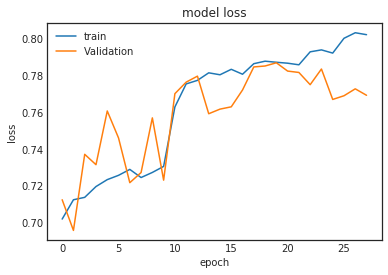

In [9]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

0.43333333333333335 (800, 101, 101)


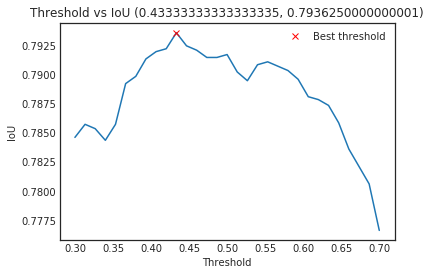

In [10]:
model = load_model(best_model_f, custom_objects={'my_iou_metric': my_iou_metric})
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    x_test_reflect3 = np.array([np.flipud(x) for x in x_test])
    preds_test1 = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    
    preds_test3_refect = model.predict(x_test_reflect3).reshape(-1, img_size_target, img_size_target)
    preds_test3 = np.array([ np.flipud(x) for x in preds_test3_refect] )
    
    preds_avg = (preds_test1 + preds_test2 + preds_test3)/3
    return preds_avg

preds_valid = predict_result(model,x_valid,img_size_target)
preds_valid2 = np.array([downsample(x) for x in preds_valid])
y_valid2 = np.array([downsample(x) for x in y_valid])
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)

def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

def get_preds(p,thres):
    #return np.int32(p > thres)
    return np.array([filter_image(im) for im in p > thres], dtype=np.int32)

ious = np.array([iou_metric_batch(y_valid2, get_preds(preds_valid2,thres)) for thres in thresholds])

threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()
print(threshold_best,preds_valid.shape)

In [11]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in test_df.index]).reshape(-1, img_size_target, img_size_target, 1)
preds_test = predict_result(model,x_test,img_size_target)
import time
t1 = time.time()
pred_dict = {}
for i, idx in enumerate(test_df.index.values):
    #res = rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) 
    res = rle_encode(filter_image(downsample(preds_test[i]) > threshold_best))
    pred_dict[idx] = res
t2 = time.time()

print(t2-t1)
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('./outputs/submission13.csv')

/usr/local/lib/python3.5/dist-packages/keras_preprocessing/image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


1.4999191761016846
